In [ ]:
import sys
sys.path.insert(0,'..')
from llmdh.story_llms import *

In [2]:
len(BechdelScreenplayLLM.db)

1059

In [4]:
# BechdelScreenplayLLM.parse_all_scripts()

In [13]:
@classmethod
def get_figdf(self):
    import imdb


    dfmeta = self.get_meta()
    db = self.get_db()
    keys=[k for k in db.keys() if type(db[k]) is pd.DataFrame and len(db[k])]
    sumdf=pd.DataFrame([db[k].mean(numeric_only=True) for k in keys], index=keys).rename_axis('id').dropna()
    dfall=sumdf.merge(dfmeta,on='id')
    dfall['release_date']=pd.to_numeric(dfall['release_date'], errors='coerce')
    
    # get genres
    ia = imdb.IMDb()
    imdb_ids = dfall.imdb_id.dropna().apply(int).apply(str)
    dbgenre=SqliteDict(os.path.join(PATH_DATA,'data.imdb_genre.db'), flag='c', autocommit=True)
    for idx in tqdm(imdb_ids):
        if idx not in dbgenre:
            dbgenre[idx]=ia.get_movie(idx)
        # time.sleep(0.005)
    
    def tostr(x):
        try:
            return str(int(x))
        except:
            return ''
        
    dfall['imdb_id']=dfall.imdb_id.apply(tostr)

    dfall2 = pd.DataFrame(
        {**d, 'genre':g}
        for d in dfall.reset_index().to_dict('records')
        for g in dbgenre.get(d['imdb_id'],{}).get('genres',[])
        if g not in {'Music','Short'}
    ).set_index('id')

    return dfall2


BechdelScreenplayLLM.get_figdf = get_figdf

In [14]:
BechdelScreenplayLLM.get_figdf()

100%|██████████| 838/838 [00:00<00:00, 10948.39it/s]


,index,female_characters_speak_to_each_other,female_characters_speak_about_something_other_than_a_man,scene_num,num_female_characters,num_male_characters,name,source,file_name,script_url,tmdb_title,title,tmdb_release_date,release_date,tmdb_id,tmdb_overview,overview,imdb_title,imdb_release_date,imdb_id,dec,genre
id,,,,,,,,,,,,,,,,,,,,,,
10-Things-I-Hate-About-You,0,0.461538,0.243590,44.435897,1.641026,2.294872,10 Things I Hate About You,imsdb,10-Things-I-Hate-About-You,https://imsdb.com/scripts/10-Things-I-Hate-Abo...,10 Things I Hate About You,10 Things I Hate About You,1999-03-30,1999.0,4951.0,"On the first day at his new school, Cameron in...","On the first day at his new school, Cameron in...",10 Things I Hate About You,1999.0,147800,1990.0,Comedy
10-Things-I-Hate-About-You,0,0.461538,0.243590,44.435897,1.641026,2.294872,10 Things I Hate About You,imsdb,10-Things-I-Hate-About-You,https://imsdb.com/scripts/10-Things-I-Hate-Abo...,10 Things I Hate About You,10 Things I Hate About You,1999-03-30,1999.0,4951.0,"On the first day at his new school, Cameron in...","On the first day at his new school, Cameron in...",10 Things I Hate About You,1999.0,147800,1990.0,Drama
10-Things-I-Hate-About-You,0,0.461538,0.243590,44.435897,1.641026,2.294872,10 Things I Hate About You,imsdb,10-Things-I-Hate-About-You,https://imsdb.com/scripts/10-Things-I-Hate-Abo...,10 Things I Hate About You,10 Things I Hate About You,1999-03-30,1999.0,4951.0,"On the first day at his new school, Cameron in...","On the first day at his new school, Cameron in...",10 Things I Hate About You,1999.0,147800,1990.0,Romance
A-Dry-White-Season,1,0.220000,0.080000,32.760000,1.360000,4.940000,A Dry White Season,scriptsavant,A-Dry-White-Season,https://secureservercdn.net/198.71.233.72/p2z....,A Dry White Season,A Dry White Season,1989-01-01,1989.0,32075.0,"During the 1976 Soweto uprising, a white schoo...","During the 1976 Soweto uprising, a white schoo...",A Dry White Season,1989.0,97243,1980.0,Drama
A-Dry-White-Season,1,0.220000,0.080000,32.760000,1.360000,4.940000,A Dry White Season,scriptsavant,A-Dry-White-Season,https://secureservercdn.net/198.71.233.72/p2z....,A Dry White Season,A Dry White Season,1989-01-01,1989.0,32075.0,"During the 1976 Soweto uprising, a white schoo...","During the 1976 Soweto uprising, a white schoo...",A Dry White Season,1989.0,97243,1980.0,Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Poltergeist,838,0.232323,0.171717,82.393939,1.212121,1.666667,Poltergeist,scriptsavant,Poltergeist,https://secureservercdn.net/198.71.233.72/p2z....,Poltergeist,Poltergeist,2015-05-20,1982.0,243688.0,A family's suburban home is invaded by angry s...,A family's suburban home is invaded by angry s...,Poltergeist,1982.0,84516,1980.0,Horror
Poltergeist,838,0.232323,0.171717,82.393939,1.212121,1.666667,Poltergeist,scriptsavant,Poltergeist,https://secureservercdn.net/198.71.233.72/p2z....,Poltergeist,Poltergeist,2015-05-20,1982.0,243688.0,A family's suburban home is invaded by angry s...,A family's suburban home is invaded by angry s...,Poltergeist,1982.0,84516,1980.0,Thriller
Butterfly-Effect-The,839,0.171171,0.036036,87.252252,0.729730,2.099099,"Butterfly Effect, The",imsdb,Butterfly-Effect-The,https://imsdb.com/scripts/Butterfly-Effect%2C-...,The Butterfly Effect,The Butterfly Effect,2004-01-22,2004.0,1954.0,A young man struggles to access sublimated chi...,A young man struggles to access sublimated chi...,The Butterfly Effect,2004.0,289879,2000.0,Drama


In [15]:

@classmethod
def plot_boxplot(self, y='female_characters_speak_about_something_other_than_a_man'):
    dfall2 = self.get_figdf()
    genres=dfall2.genre.value_counts()
    genres=genres[genres>=20].index
    genreorder=dfall2.groupby('genre')[y].median().sort_values(ascending=False).index
    dfall2['genre']=pd.Categorical(dfall2['genre'], categories=genreorder)
    figdf=dfall2[dfall2.genre.isin(genres)]
    genreorderl=[g for g in genreorder if g in genres]
    fig=p9.ggplot(figdf[figdf.genre!=""], p9.aes(x='genre', y=y))
    fig+=p9.geom_boxplot(outlier_shape='')
    fig+=p9.geom_point(shape='x')
    fig+=p9.coord_flip()
    fig+=p9.scale_x_discrete(limits=genreorderl)
    # fig+=p9.theme_minimal()
    fig+=p9.labs(
        x='Primary genre of film',
        y=f'% scenes in which {y.replace("_"," ")}',
        title='Comparing genres for Bechdel test'
    )
    return fig

BechdelScreenplayLLM.plot_boxplot = plot_boxplot

100%|██████████| 838/838 [00:00<00:00, 8906.16it/s]


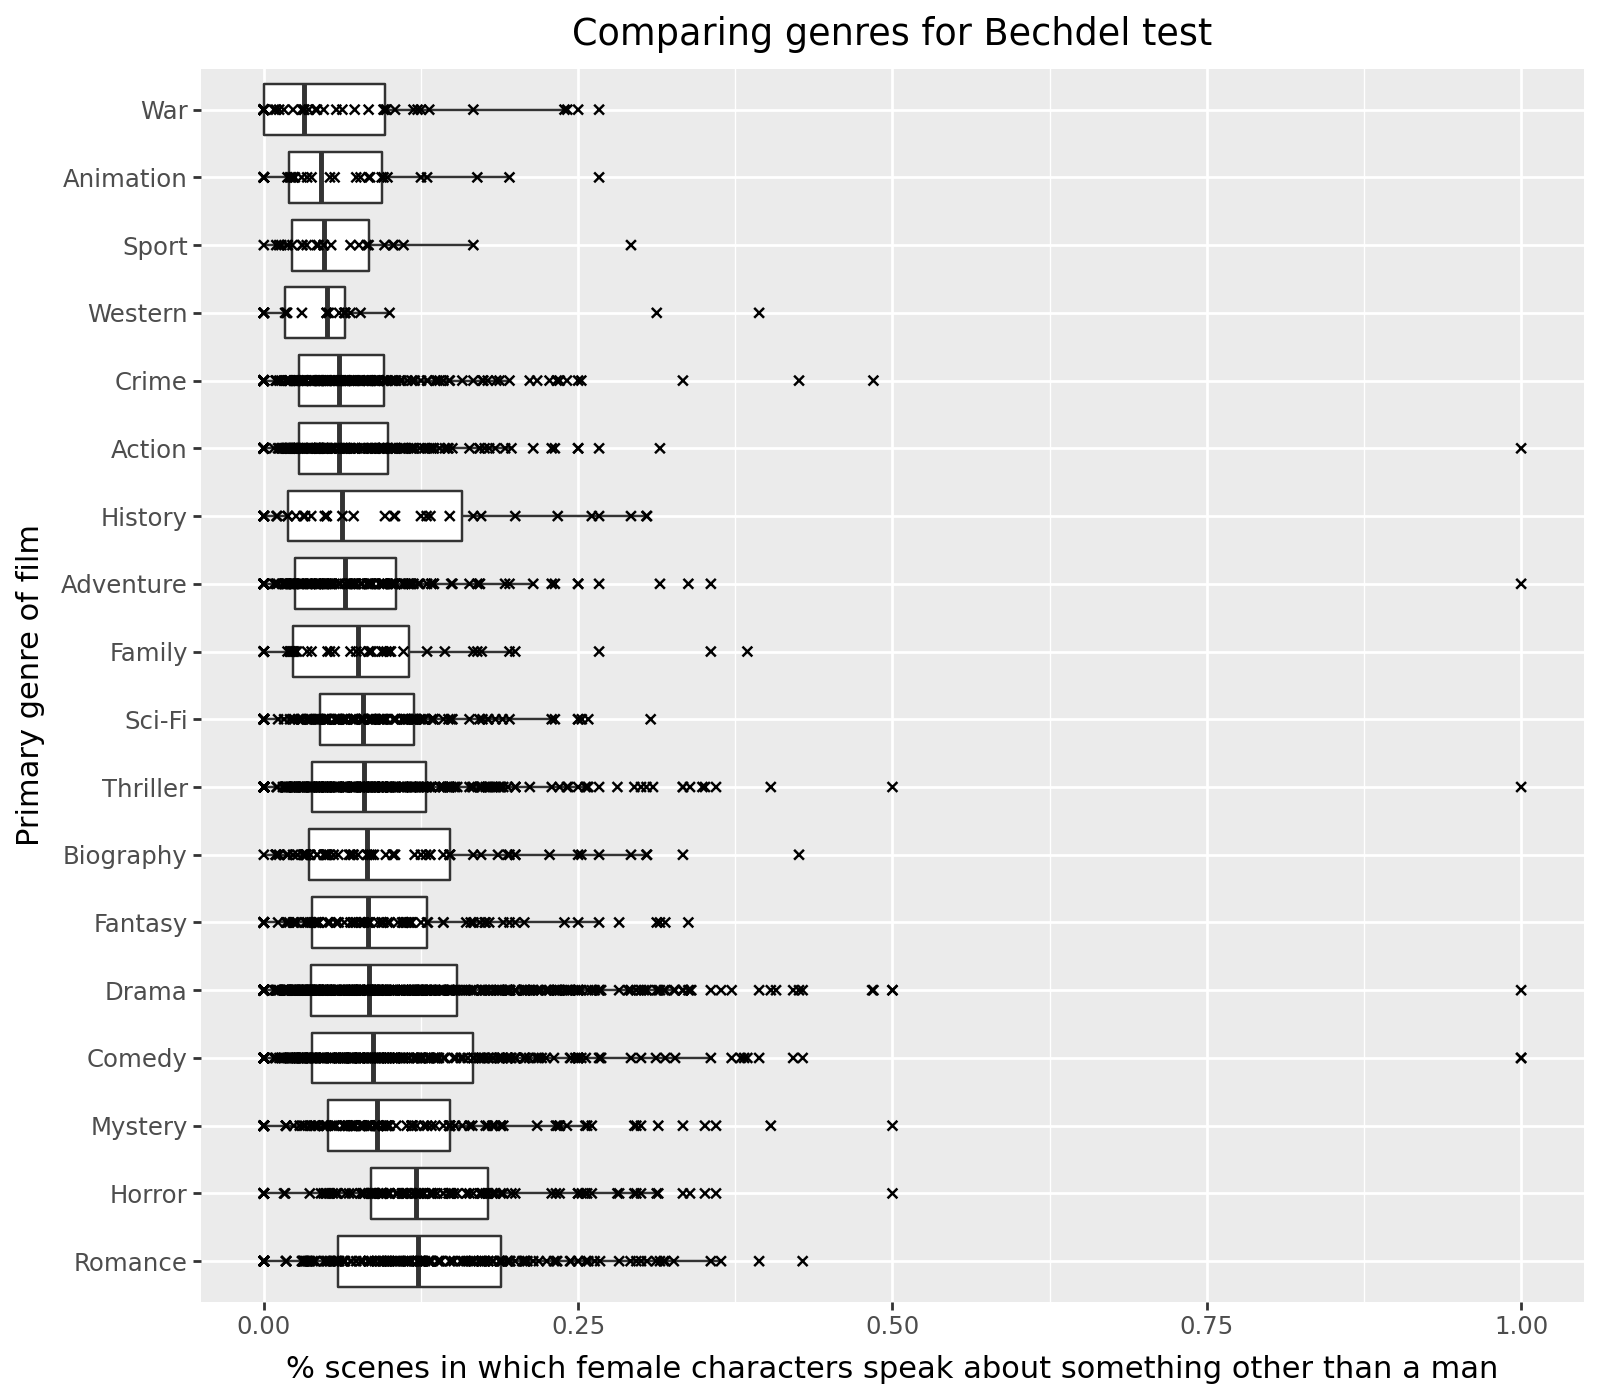

In [16]:
BechdelScreenplayLLM.plot_boxplot()

100%|██████████| 838/838 [00:00<00:00, 10471.48it/s]


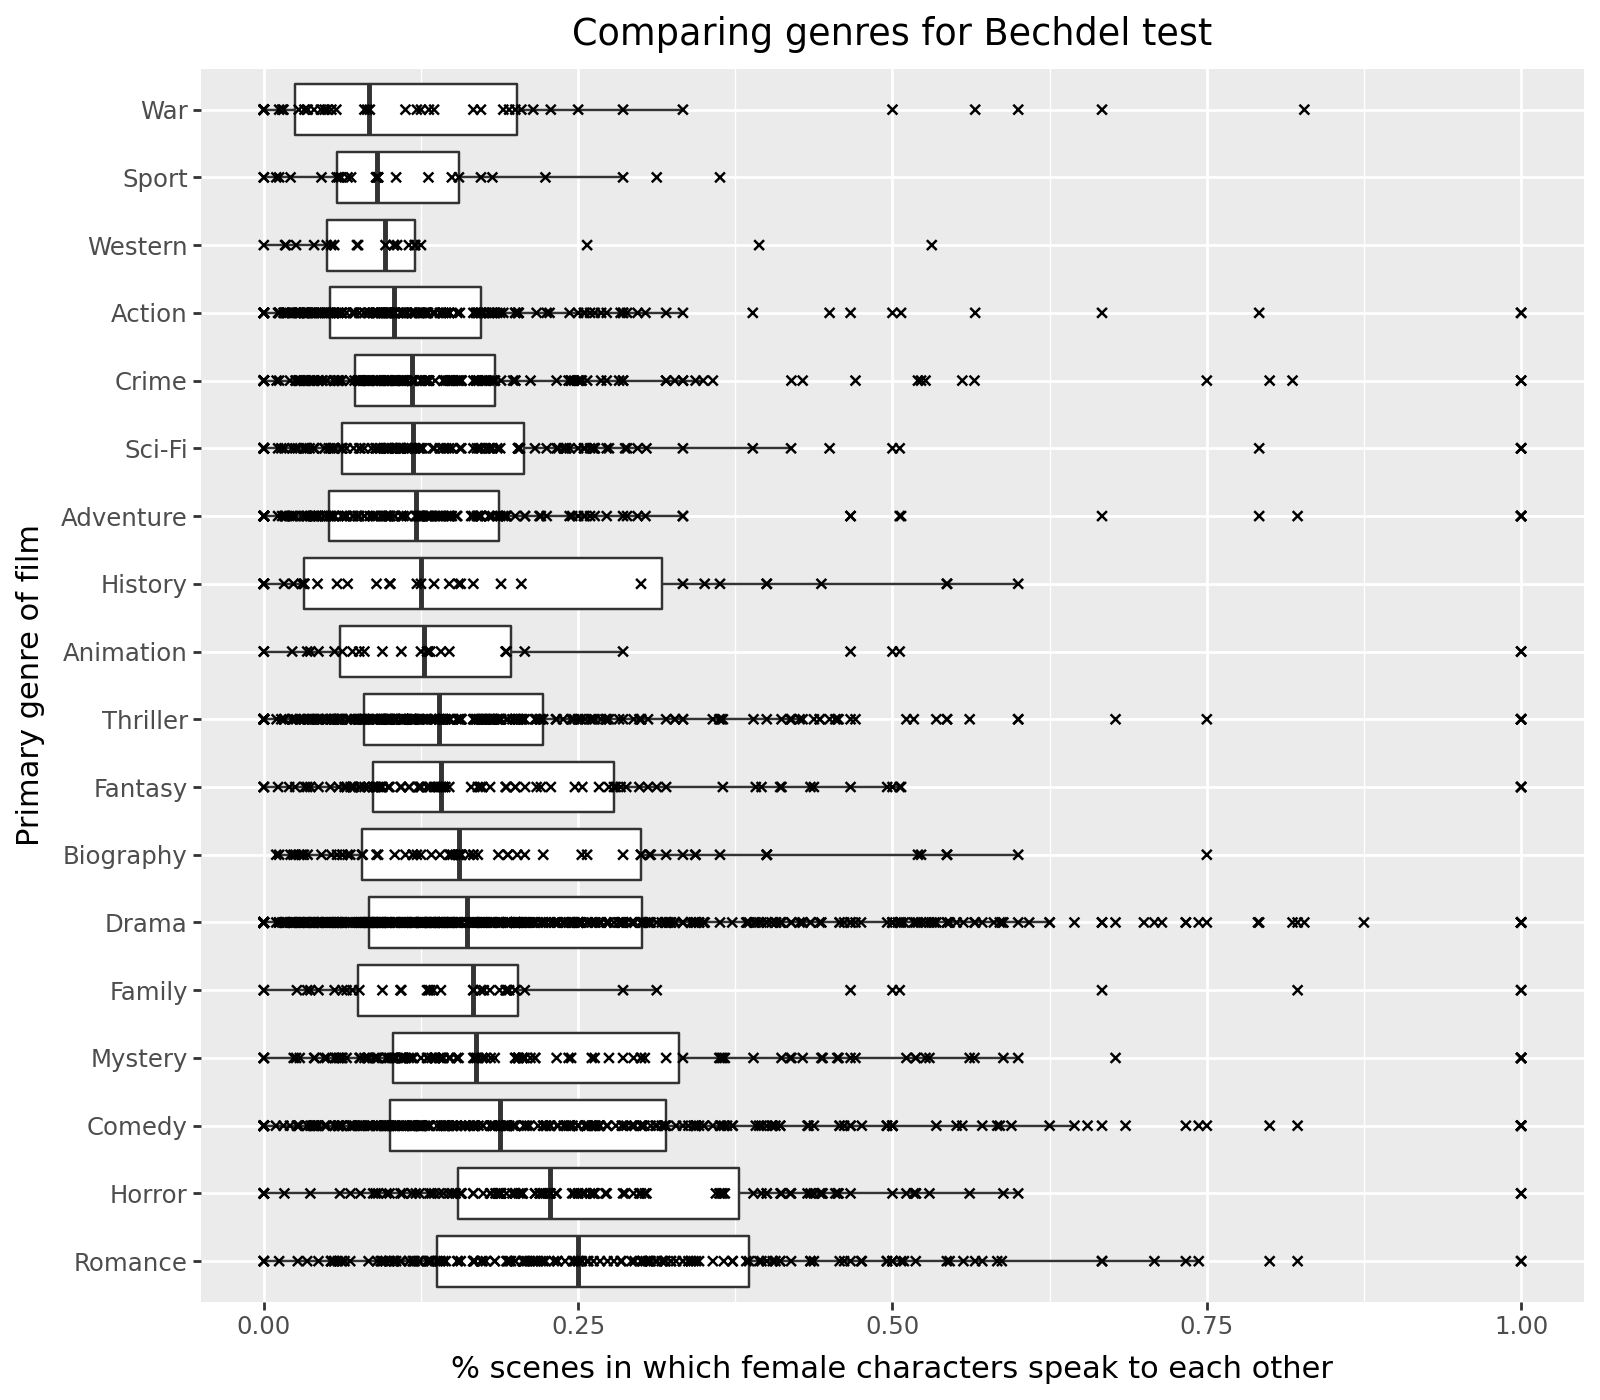

In [17]:
BechdelScreenplayLLM.plot_boxplot('female_characters_speak_to_each_other')

In [36]:
@classmethod
def plot_genre_biplot(self, x='female_characters_speak_to_each_other', y='female_characters_speak_about_something_other_than_a_man'):
    dfall2 = self.get_figdf()
    figdf=pd.concat(gdf for g,gdf in dfall2.groupby('genre') if len(gdf)>=20)
    figdf[x]*=100
    figdf[y]*=100
    dfgenres=figdf.groupby('genre').median(numeric_only=True)
    dfgenres['count']=figdf.genre.value_counts()
    fig = p9.ggplot(dfgenres.reset_index(), p9.aes(x=x, y=y, label='genre'))
    fig += p9.geom_smooth(method='lm', color='blue', alpha=.25, size=.5)
    # fig += p9.geom_point(p9.aes(size='count'), alpha=.25)
    fig += p9.geom_text()
    # fig += p9.geom_abline(intercept=0, slope=1, color='blue')
    # fig += p9.scale_x_continuous(limits=(0,25))
    # fig += p9.scale_y_continuous(limits=(0,12.5))
    fig+=p9.theme_minimal()
    fig+=p9.labs(
        x=f'% scenes in which {x.replace("_", " ")}',
        y=f'% scenes in which {y.replace("_", " ")}',
        title='Bechdel test components by genre'
    )
    fig.save('fig.genre_biplot.png')
    return fig

BechdelScreenplayLLM.plot_genre_biplot = plot_genre_biplot

100%|██████████| 838/838 [00:00<00:00, 9808.61it/s]


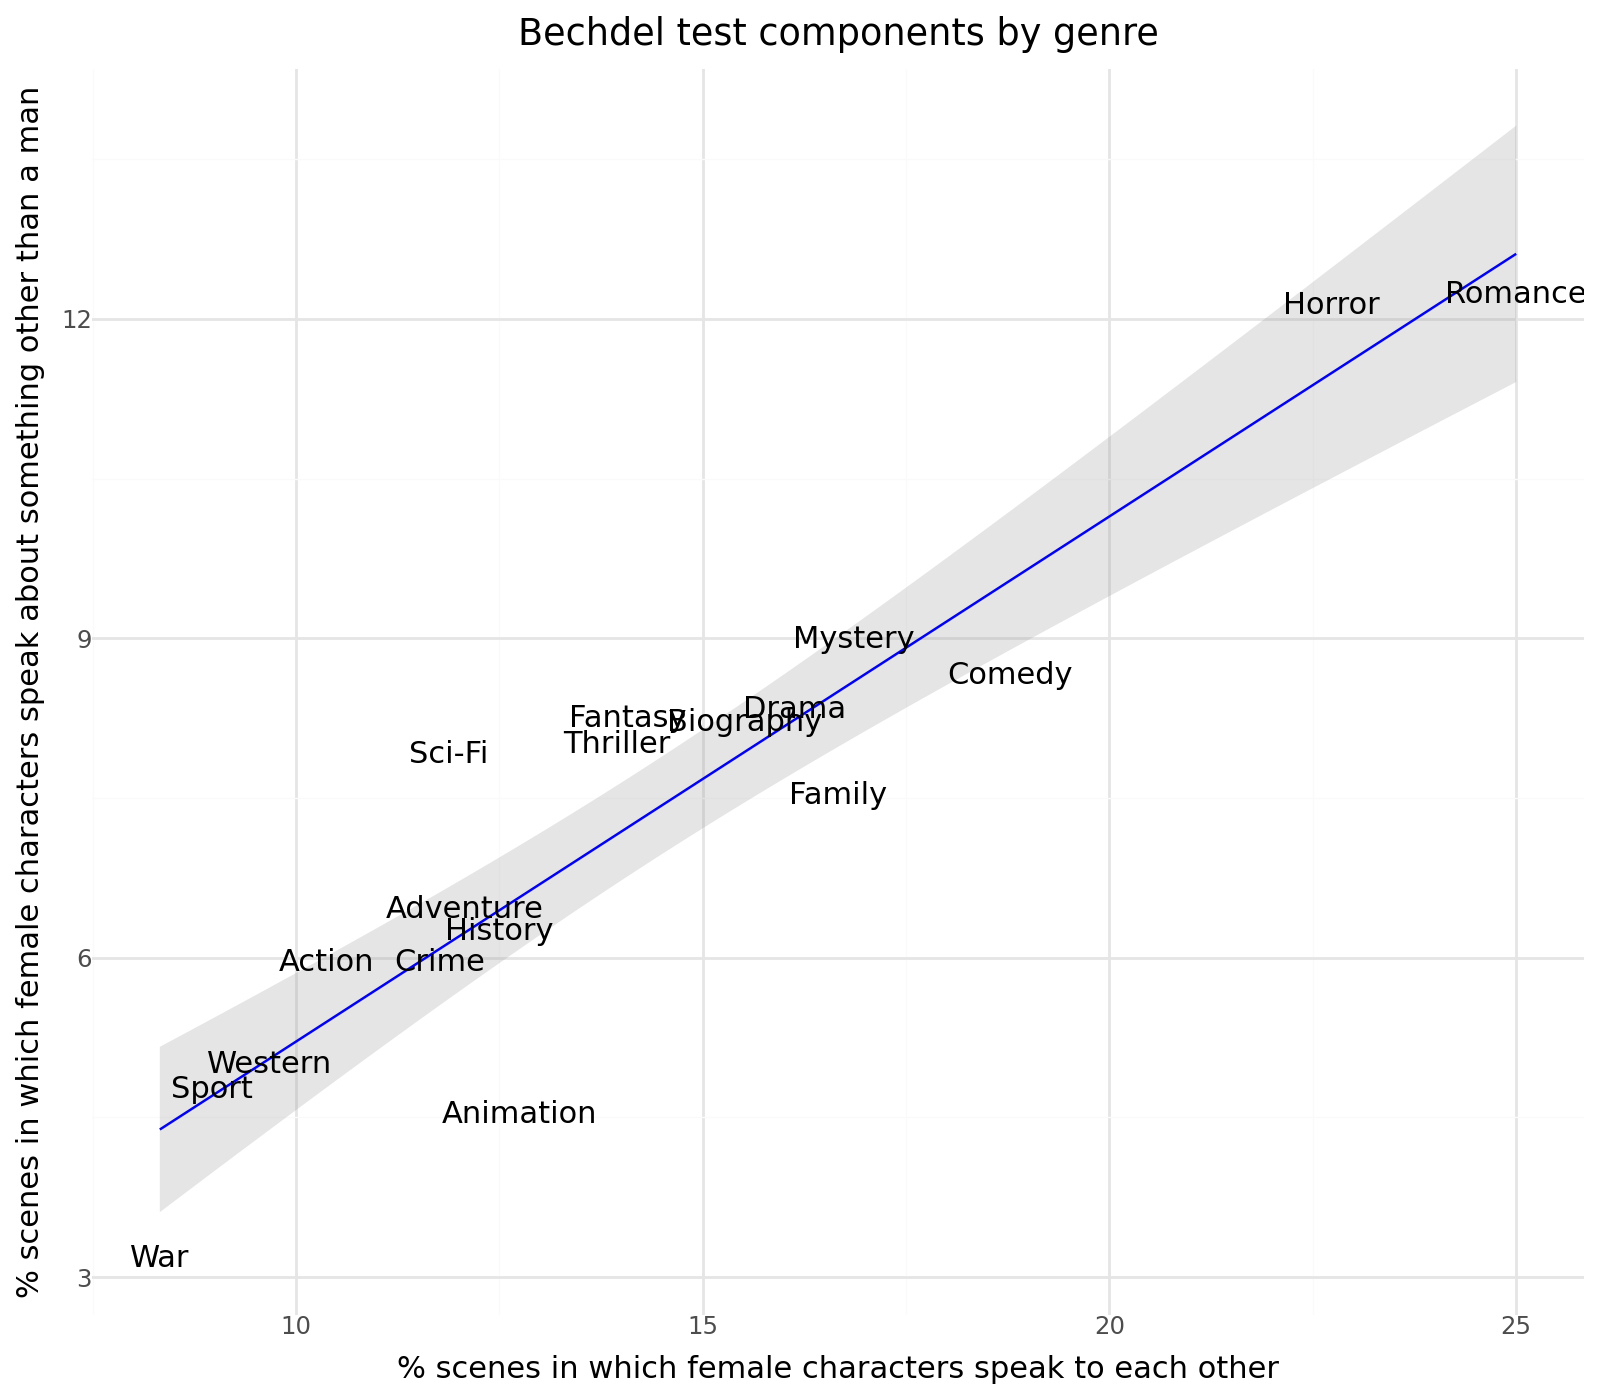

In [37]:
BechdelScreenplayLLM.plot_genre_biplot()